# Install Qiskit to the cloud

In [ ]:
!pip install qiskit

     |████████████████████████████████| 8.3MB 2.7MB/s 
     |████████████████████████████████| 16.5MB 250kB/s 
     |████████████████████████████████| 163kB 47.2MB/s 
     |████████████████████████████████| 174kB 49.8MB/s 
     |████████████████████████████████| 1.9MB 36.1MB/s 
     |████████████████████████████████| 5.8MB 45.1MB/s 
     |████████████████████████████████| 962kB 33.9MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 296kB 35.5MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 583kB 39.9MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 2.7MB 44.3MB/s 
  Created wheel for qiskit: filename=qiskit-0.20.0-cp36-none-any.whl size=3024 sha256=3ee6760f448cae23ea6dbe48a01b506d1eb7c9bb094546aead2539c0ba75bb9f
  Stored in directory: /root/.cache/pip/wheels/72/97/19/dd8931ed9c3115e216522129025614effb4494c96aad7fea0d
  Created wheel for

In [ ]:
!git clone --branch mnist https://github.com/Coldog2333/qc_group_project.git

Cloning into 'qc_group_project'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 272 (delta 84), reused 222 (delta 46), pack-reused 0
Receiving objects: 100% (272/272), 37.22 MiB | 11.42 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
%cd /content/qc_group_project

/content/qc_group_project


# Utilities

In [ ]:
# Data preprocessing
def get_breast_cancer_data():
    # Read the data
    df = pd.read_csv('breast-cancer.data', \
                     header=None, \
                     names=['target', \
                            'age', \
                            'menopause', \
                            'tumor-size', \
                            'inv-nodes', \
                            'node-caps', \
                            'deg-malig', \
                            'breast', \
                            'breast-quad', \
                            'irradiat'])  
    # Ordinal Encoding
    for col in df.columns:
      df[col] = LabelEncoder().fit_transform(df[col])
  
    return df.drop(['target'], axis=1), df.target

# K-fold Random Forest Classification
def kfold_randomforest(X, y, k=5):
    print('='*50)
    print(f'{k}-fold Random Forest Classification')
    acc_list, f1_list, feature_importances_list = [], [], []
    for train_id, test_id in KFold(n_splits=k, shuffle=True).split(X):
        # Split the data
        X_train, X_test, y_train, y_test = X[train_id], X[test_id], y[train_id], y[test_id]
        # Train the model
        rf_classifier = RandomForestClassifier()
        rf_classifier.fit(X_train, y_train)
        # Get scores and feature importances
        acc_list.append(rf_classifier.score(X_test, y_test))
        f1_list.append(f1_score(y_test, rf_classifier.predict(X_test)))
        feature_importances_list.append(rf_classifier.feature_importances_)

    # Average accuracy and f1 score
    print(f'Mean Accuracy: {np.mean(acc_list):.2%}')
    print(f'Mean F1 score: {np.mean(f1_list):.2%}')
    print('='*50)

    return acc_list, f1_list, feature_importances_list

# Dictionary to feed VQC
def get_input_dict_for_VQC(X_train, X_test, y_train, y_test):
    training_input = { 0: X_train[y_train == 0],
                       1: X_train[y_train == 1]}
    test_input = { 0: X_test[y_test == 0],
                   1: X_test[y_test == 1] }
    return training_input, test_input

# Train VQC
def train_vqc(feature_map, \
              var_form, \
              backend, \
              optimizer, \
              seed, \
              X_train, X_test, y_train, y_test, \
              model_filename, \
              shots=1024):
  
    # Input preparation
    # Input dict
    training_input, test_input = get_input_dict_for_VQC(X_train, X_test, y_train, y_test)
    # Quantum instance
    quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)
    # Final zip file for temp models and its working directory
    wdir = '/'.join(model_filename.split('/')[:-1])
    print('='*100 + f'\nWorking directory: {wdir}\n' + '='*100)  
    os.chdir(wdir)  
    temp_model_zip_filename = model_filename.split('.')[0] + '_temp.zip'
    final_model_filename = model_filename.split('.')[0] + '_final.npz'
    zip_obj = ZipFile(temp_model_zip_filename, 'w')

    # Callback function for collecting models' parameters and losses along the way
    default_training_loss_list, training_loss_list, validation_loss_list = [], [], []
    def callback_collector(eval_count, model_params, loss, ___):
        # Collect default training loss
        default_training_loss_list.append(loss)
        # Save a temp model
        temp_model_filename = model_filename.split('.')[0] + f'_evalcount{eval_count+1}.npz'
        np.savez(temp_model_filename, opt_params = model_params)
        zip_obj.write(temp_model_filename.split('/')[-1], compress_type=ZIP_DEFLATED)
        # Load the temp model
        vqc_val = VQC(optimizer, feature_map, var_form, training_input, test_input)
        vqc_val.load_model(temp_model_filename)
        os.remove(temp_model_filename)
        # Collect validation loss
        y_test_prob = vqc_val.predict(X_test, quantum_instance)[0]
        val_loss = -np.mean(y_test*np.log(y_test_prob[:,1]) + (1 - y_test)*np.log(y_test_prob[:,0]))
        validation_loss_list.append(val_loss)
        # Collect training loss
        y_train_prob = vqc_val.predict(X_train, quantum_instance)[0]
        train_loss = -np.mean(y_train*np.log(y_train_prob[:,1]) + (1 - y_train)*np.log(y_train_prob[:,0]))
        training_loss_list.append(train_loss)

    # Run VQC
    vqc = VQC(optimizer, feature_map, var_form, training_input, test_input, callback=callback_collector)
    result = vqc.run(quantum_instance)
    clear_output()
    print('Trained successfully!')
    vqc.save_model(final_model_filename)
    zip_obj.close()

    # Evaluate a final model
    y_train_pred, y_test_pred = vqc.predict(X_train, quantum_instance)[1], vqc.predict(X_test,  quantum_instance)[1]
    acc_train, f1_train = np.mean(y_train_pred==y_train), f1_score(y_train, y_train_pred)
    acc_test, f1_test = np.mean(y_test_pred==y_test), f1_score(y_test, y_test_pred)
    clear_output()
    print(f'Final accuracy (test set): {acc_test:.2%} | Final accuracy (training set): {acc_train:.2%}')
    print(f'Final F1 score (test set): {f1_test:.2%} | Final F1 score (training set): {f1_train:.2%}')
    print(f'Final model is saved at {final_model_filename}.\nTemp models are saved at {temp_model_zip_filename}.')

    # Save results
    result['Default training losses'] = np.array(default_training_loss_list)
    result['Training losses'] = np.array(training_loss_list)
    result['Validation losses'] = np.array(validation_loss_list)
    result['Training F1 score'], result['Training accuracy'] = f1_train, acc_train
    result['Test F1 score'], result['Test accuracy'] = f1_test, acc_test

    return result

def kfold_vqc(feature_map, \
              var_form, \
              backend, \
              optimizer, \
              seed, \
              X, y, \
              model_filename, \
              result_filename, \
              k=5, \
              shots=1024, \
              seed_kfold=123123, \
              double_positive_data=True):

    print('='*100)
    print(f'{k}-fold VQC Classification')
    # Final zip file for saving and its directory
    wdir = '/'.join(model_filename.split('/')[:-1])
    print('='*100 + f'\nWorking directory: {wdir}\n' + '='*100)
    os.chdir(wdir)
    zip_filename = model_filename.split('.')[0] + '.zip'
    zip_obj = ZipFile(zip_filename, 'w')
    # Final result initialization (dict)
    result = dict()
    result['Default training losses'], result['Training losses'], result['Validation losses'] = [], [], []
    result['Default final test losses'], result['Default test accuracies'] = [], []
    result['Training accuracies'], result['Test accuracies'], result['Test F1 scores'], result['Training F1 scores'] = [], [], [], []
    np.random.seed(seed_kfold)
    for (fold, (train_id, test_id)) in enumerate(KFold(n_splits=k, shuffle=True).split(X), start=1):
        print('='*100 + f'\nFold number {fold}\n' + '='*100)
        # Split data
        X_train, X_test, y_train, y_test = X[train_id], X[test_id], y[train_id], y[test_id]
        # Double positive data
        if double_positive_data:
            X_train, y_train = np.concatenate((X_train, X_train[y_train==1]), axis=0), np.hstack((y_train, np.ones(np.sum(y_train==1))))
        # Train a model
        model_filename_fold = model_filename.split('.')[0] + f'_foldnumber{fold}.npz'
        result_1fold = train_vqc(feature_map, \
                                var_form, \
                                backend, \
                                optimizer, \
                                seed, \
                                X_train, X_test, y_train, y_test, \
                                model_filename_fold, \
                                shots)
        # Save the trained model to the final zip file 
        # Final model
        final_model_filename_fold = model_filename_fold.split('.')[0] + '_final.npz'
        zip_obj.write(final_model_filename_fold.split('/')[-1], compress_type=ZIP_DEFLATED)
        os.remove(final_model_filename_fold)
        # Temp model
        temp_model_zip_filename_fold = model_filename_fold.split('.')[0] + '_temp.zip'
        zip_obj.write(temp_model_zip_filename_fold.split('/')[-1], compress_type=ZIP_DEFLATED)
        os.remove(temp_model_zip_filename_fold)
        # Collect results
        result['Default training losses'].append(result_1fold['Default training losses'])
        result['Training losses'].append(result_1fold['Training losses'])
        result['Validation losses'].append(result_1fold['Validation losses'])
        result['Default final test losses'].append(result_1fold['testing_loss'])
        result['Training accuracies'].append(result_1fold['Training accuracy'])
        result['Test accuracies'].append(result_1fold['Test accuracy'])
        result['Training F1 scores'].append(result_1fold['Training F1 score'])
        result['Test F1 scores'].append(result_1fold['Test F1 score'])
        result['Default test accuracies'].append(result_1fold['testing_accuracy'])

    # Average accuracies and f1 scores
    zip_obj.close()
    dict_items_without_meanvalues = list(result.items())
    for key, value in dict_items_without_meanvalues:
        result['Mean ' + key.lower()] = np.mean(value, axis=0)
    # Make all numpy arrays
    for key, value in result.items():
        if type(value)==list:
            result[key] = np.array(value)
    # Save final results
    with open(result_filename, 'wb') as f:
        pickle.dump(result, f)
    clear_output()
    print('='*100)
    print('='*35 + f' {k}-fold VQC Classification ' + '='*35)
    print(f"Mean training accuracy: {result['Mean training accuracies']:.2%} | Mean test accuracy: {result['Mean test accuracies']:.2%}")
    print(f"Mean training F1 score: {result['Mean training f1 scores']:.2%} | Mean test F1 score: {result['Mean test f1 scores']:.2%}")
    print(f'All models are saved at {zip_filename}.\nResults are saved at {result_filename}.')
    print('='*100)

    return result

# Convert a 3-bit string into inputs for U3 gate
def convert_to_angle(b_st):
    if b_st=='111':
        return [np.arccos(1/np.sqrt(3)), np.pi/4]
    if b_st=='110':
        return [np.arccos(1/np.sqrt(3)), 3*np.pi/4]
    if b_st=='101':
        return [np.arccos(1/np.sqrt(3)), -np.pi/4]
    if b_st=='100':
        return [np.arccos(1/np.sqrt(3)), -3*np.pi/4]
    if b_st=='011':
        return [np.arccos(-1/np.sqrt(3)), np.pi/4]
    if b_st=='010':
        return [np.arccos(-1/np.sqrt(3)), 3*np.pi/4]
    if b_st=='001':
        return [np.arccos(-1/np.sqrt(3)), -np.pi/4]
    if b_st=='000':
        return [np.arccos(-1/np.sqrt(3)), -3*np.pi/4]

# Binary Encoder
def binary_encoder(X):
    # The number of necessary bits in each column
    bit_each_col = [int(np.ceil(np.log2(len(np.unique(X[:,col]))))) for col in range(X.shape[1])]
    # Padding check in order to make an input string into quantum circuit divisible by three
    if sum(bit_each_col)%3 != 0:
        pad = 3 - (sum(bit_each_col)%3)
    else:
        pad = 0 
    # Encode X into a binary string
    X_binary_encoded = []
    for sample in X:
        bit_string = ''
        for value, num_bit in zip(sample, bit_each_col):
            bit_string += f'{value:010b}'[-num_bit:]
        bit_string += pad*'0'
        X_binary_encoded.append(bit_string)
    return np.array(X_binary_encoded)

# U3gate Input Encoder
def U3gate_input_encoder(X):
    X_binary_encoded = binary_encoder(X)
    if len(X_binary_encoded[0]) % 3 != 0:
        raise ValueError('The input string is not divisible by three')
    else:
        X_U3gate_input = []
        for bitstring in X_binary_encoded:
            U3gate_input = []
            for qubit in range(len(X_binary_encoded[0])//3):
                U3gate_input.extend(convert_to_angle(bitstring[qubit*3: (qubit+1)*3]))
            X_U3gate_input.append(U3gate_input)
        return np.array(X_U3gate_input)

# Implementation

## Import Libraries

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
from IPython.display import clear_output
from zipfile import ZipFile, ZIP_DEFLATED
import pickle

In [ ]:
%load_ext autoreload
%autoreload 2
from qiskit import BasicAer
from qiskit.providers.aer import QasmSimulator
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from quantum_utils import CustomFeatureMap

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

## Data Preprocessing

In [ ]:
X_df, y_df = get_breast_cancer_data()
X, y = X_df.values, y_df.values

##  Random Forest Classifier

### Feature Selection by 5-fold cross-validated Random Forest Algorithm

5-fold Random Forest Classification
Mean Accuracy: 71.65%
Mean F1 score: 40.90%
The four most important features are TUMOR-SIZE, BREAST-QUAD, DEG-MALIG and AGE respectively.


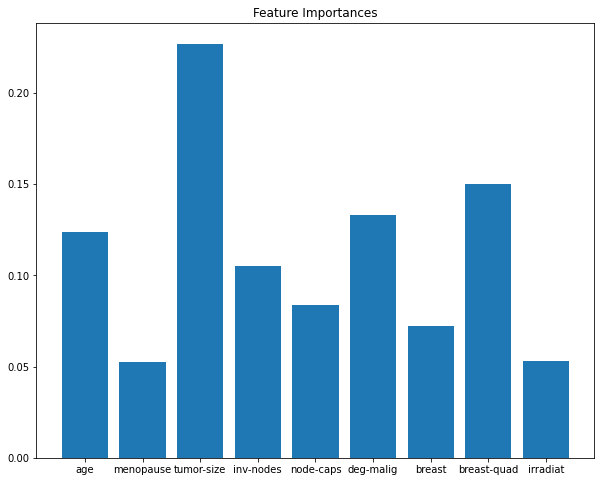

In [ ]:
np.random.seed(123123)
selected_features_num = 4
_, __, feature_importances_list = kfold_randomforest(X, y)

# Feature selection from feature importances
selected_features = X_df.columns[sorted(range(X.shape[1]), key=lambda i: np.mean(feature_importances_list, axis=0)[i])[:-selected_features_num-1:-1]]
print('The four most important features are', ", ".join(selected_features[:-1]).upper() + f' and {selected_features[-1].upper()} respectively.')

# Visualize the feature importances
plt.figure(figsize=(10,8))
plt.bar(X_df.columns, np.mean(feature_importances_list, axis=0))
plt.title('Feature Importances')
plt.show()

### Random Forest Classification on the selected features with 5-fold cross-validation

In [ ]:
np.random.seed(123123)
_,_,_ = kfold_randomforest(X_df[selected_features].values, y)

5-fold Random Forest Classification
Mean Accuracy: 66.44%
Mean F1 score: 37.92%


## Variational Quantum Classfier


### Ordinal Input

#### Test Run

In [ ]:
# Select only the important features
X, y = X_df[selected_features].values, y_df.values

# Preparing inputs for feeding VQC
feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=3, entanglement='linear')
var_form = variational_forms.RYRZ(X.shape[1], depth=4)
backend = QasmSimulator({"method": "statevector_gpu"})
seed, epoch = 10598, 2
optimizer = SPSA(epoch)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Double the positive data
X_train, y_train = np.vstack((X_train, X_train[y_train==1])), np.hstack((y_train, np.ones(np.sum(y_train==1))))

# Test Run VQC
result_vqc = train_vqc(feature_map, \
                  var_form, \
                  backend, \
                  optimizer, \
                  seed, \
                  X_train, X_test, y_train, y_test, \
                  '/content/qc_group_project/models/test_model.npz')

Final accuracy (test set): 53.45% | Final accuracy (training set): 48.31%
Final F1 score (test set): 30.77% | Final F1 score (training set): 44.77%
Final model is saved at /content/qc_group_project/models/test_model_final.npz.
Temp models are saved at /content/qc_group_project/models/test_model_temp.zip.


In [ ]:
result_vqc

{'Default training losses': array([0.7534215 , 0.73637361, 0.72665206, 0.76679912, 0.70401026,
        0.68285767, 0.74581334]),
 'Test F1 score': 0.30769230769230765,
 'Test accuracy': 0.5344827586206896,
 'Training F1 score': 0.44765342960288806,
 'Training accuracy': 0.4831081081081081,
 'Training losses': array([0.7550775 , 0.73890743, 0.72560624, 0.76570465, 0.707281  ,
        0.68625514, 0.74736807]),
 'Validation losses': array([0.76892787, 0.76811123, 0.75725074, 0.78189397, 0.74725768,
        0.75280225, 0.7095376 ]),
 'eval_count': 7,
 'eval_time': 73.0591835975647,
 'min_val': 0.7458133392397314,
 'num_optimizer_evals': None,
 'opt_params': array([-2.90744214, -1.2343578 ,  1.89375614,  0.79376435,  0.77488305,
        -1.32670685,  1.33220879, -1.70865404,  0.56736263, -1.68990081,
         0.70404624,  2.68431982,  0.91673836, -1.91110247, -0.8658053 ,
        -1.82002651,  2.05611055, -2.23746488, -1.64581591, -1.6309093 ,
        -3.37449379, -0.53716242, -2.52298404, 

In [ ]:
# Test Run KFold VQC
# Select only the important features
X, y = X_df[selected_features].values, y_df.values

# Preparing inputs for feeding VQC
feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=3, entanglement='linear')
var_form = variational_forms.RYRZ(X.shape[1], depth=4)
backend = QasmSimulator({"method": "statevector_gpu"})
seed, epoch = 10598, 2
optimizer = SPSA(epoch)
result = kfold_vqc(feature_map, \
                  var_form, \
                  backend, \
                  optimizer, \
                  seed, \
                  X, y, \
                  '/content/qc_group_project/models/test_kfoldmodel.zip', \
                  '/content/qc_group_project/results/test_kfoldmodel_results.pkl', \
                  k=2)

=================================== 2-fold VQC Classification ===================================
Mean training accuracy: 50.97% | Mean test accuracy: 48.95%
Mean training F1 score: 48.30% | Mean test F1 score: 39.29%
All models are saved at /content/qc_group_project/models/test_kfoldmodel.zip.
Results are saved at /content/qc_group_project/results/test_kfoldmodel_results.pkl.


In [ ]:
with open('/content/qc_group_project/results/test_kfoldmodel_results.pkl', 'rb') as f:
    read_result = pickle.load(f)
read_result

{'Default final test losses': array([0.76731142, 0.71029367]),
 'Default test accuracies': array([0.44055944, 0.53846154]),
 'Default training losses': array([[0.68143742, 0.69275214, 0.69409558, 0.67853963, 0.70618085,
         0.70808165, 0.70830104],
        [0.74068129, 0.76564569, 0.74984686, 0.75152261, 0.69781272,
         0.70724823, 0.70486364]]),
 'Mean default final test losses': 0.738802543189939,
 'Mean default test accuracies': 0.4895104895104895,
 'Mean default training losses': array([0.71105936, 0.72919892, 0.72197122, 0.71503112, 0.70199678,
        0.70766494, 0.70658234]),
 'Mean test accuracies': 0.4895104895104895,
 'Mean test f1 scores': 0.39293659621802,
 'Mean training accuracies': 0.5096685082872928,
 'Mean training f1 scores': 0.48303643074947844,
 'Mean training losses': array([0.71105936, 0.72919892, 0.72197122, 0.71503112, 0.70199678,
        0.70766494, 0.70658234]),
 'Mean validation losses': array([0.74350897, 0.74388174, 0.72842882, 0.75535381, 0.74369

#### Real Implemetation

In [ ]:
# Real Implementation
# Select only the important features
X, y = X_df[selected_features].values, y_df.values

# Preparing inputs for feeding VQC
feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=3, entanglement='linear')
backend = QasmSimulator({"method": "statevector_gpu"})
seed, epoch = 10598, 200
optimizer = SPSA(epoch)

# Depth 4
var_form = variational_forms.RYRZ(X.shape[1], depth=4)
result_bc_ordinalvqc_ryrzdepth4 = kfold_vqc(feature_map, \
                                            var_form, \
                                            backend, \
                                            optimizer, \
                                            seed, \
                                            X, y, \
                                            '/content/qc_group_project/models/bc_ordinalvqc_ryrzdepth4_model.zip', \
                                            '/content/qc_group_project/results/bc_ordinalvqc_ryrzdepth4_results.pkl', \
                                            k=5)

=================================== 5-fold VQC Classification ===================================
Mean training accuracy: 53.61% | Mean test accuracy: 45.45%
Mean training F1 score: 50.43% | Mean test F1 score: 28.61%
All models are saved at /content/qc_group_project/models/bc_ordinalvqc_ryrzdepth4_model.zip.
Results are saved at /content/qc_group_project/results/bc_ordinalvqc_ryrzdepth4_results.pkl.


In [ ]:
# Depth 8
var_form = variational_forms.RYRZ(X.shape[1], depth=8)
result_bc_ordinalvqc_ryrzdepth8 = kfold_vqc(feature_map, \
                                            var_form, \
                                            backend, \
                                            optimizer, \
                                            seed, \
                                            X, y, \
                                            '/content/qc_group_project/models/bc_ordinalvqc_ryrzdepth8_model.zip', \
                                            '/content/qc_group_project/results/bc_ordinalvqc_ryrzdepth8_results.pkl', \
                                            k=5)

2020-08-21 03:03:01,861:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.15.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': 3}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-08-21 03:03:01,865:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592

Final accuracy (test set): 50.00% | Final accuracy (training set): 52.51%
Final F1 score (test set): 38.30% | Final F1 score (training set): 50.00%
Final model is saved at /content/qc_group_project/models/bc_ordinalvqc_ryrzdepth8_model_foldnumber1_final.npz.
Temp models are saved at /content/qc_group_project/models/bc_ordinalvqc_ryrzdepth8_model_foldnumber1_temp.zip.
Fold number 2
Working directory: /content/qc_group_project/models


2020-08-21 03:03:06,392:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-21 03:03:07,744:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-08-21 03:03:08,971:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-21 03:03:09,232:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-08-21 03:03:13,305:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-21 03:03:14,850:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7337030873410654
2020-08-21 03:03:18,869:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-21 03:03:20,219:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-08-21 03:03:21,372:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-21 03:03:21,748:qiskit.aqua.algorith

### QRAC (3,1)
$b_1b_2b_3\Rightarrow(\theta,\varphi)\ ; b_i\in\{-1,1\} $

#### Test Run

In [ ]:
# Preparing data
X, y = X_df[selected_features].values, y_df.values
X_binary_encoded, X_U3gate_input = binary_encoder(X), U3gate_input_encoder(X)

# Preparing inputs for feeding VQC
num_qubit = len(X_binary_encoded[0])//3
# Custom Feature Map
feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit)
# Manual Feature Map
# qc = QuantumCircuit(num_qubit)
# for i in range(num_qubit):
#     qc.u3(Parameter(f'x[{2*i}]'), Parameter(f'x[{2*i+1}]'), 0, i) # Encoder
# feature_map = qc
backend = QasmSimulator({"method": "statevector_gpu"})

# Test Run VQC (CustomFeatureMap)
seed, epoch = 10598, 2
optimizer = SPSA(epoch)
var_form = variational_forms.RYRZ(num_qubit, depth=1)
result_kfold_qrac31 = kfold_vqc(feature_map, \
                            var_form, \
                            backend, \
                            optimizer, \
                            seed, \
                            X_binary_encoded, y, \
                            '/content/qc_group_project/models/test_qrac31_model.zip', \
                            '/content/qc_group_project/results/test_qrac31_results.pkl', \
                            k=2)

=================================== 2-fold VQC Classification ===================================
Mean training accuracy: 52.02% | Mean test accuracy: 54.55%
Mean training F1 score: 43.18% | Mean test F1 score: 37.30%
All models are saved at /content/qc_group_project/models/test_qrac31_model.zip.
Results are saved at /content/qc_group_project/results/test_qrac31_results.pkl.


In [ ]:
# Preparing data
X, y = X_df[selected_features].values, y_df.values
X_binary_encoded, X_U3gate_input = binary_encoder(X), U3gate_input_encoder(X)

# Preparing inputs for feeding VQC
num_qubit = len(X_binary_encoded[0])//3
# Custom Feature Map
# feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit)
# Manual Feature Map
qc = QuantumCircuit(num_qubit)
for i in range(num_qubit):
    qc.u3(Parameter(f'x[{2*i}]'), Parameter(f'x[{2*i+1}]'), 0, i) # Encoder
feature_map = qc
backend = QasmSimulator({"method": "statevector_gpu"})

# Test Run VQC (Manual Feature Map)
seed, epoch = 10598, 1
optimizer = SPSA(epoch)
var_form = variational_forms.RYRZ(num_qubit, depth=1)
result_kfold_qrac31 = kfold_vqc(feature_map, \
                            var_form, \
                            backend, \
                            optimizer, \
                            seed, \
                            X_U3gate_input, y, \
                            '/content/qc_group_project/models/test_qrac31_model.zip', \
                            '/content/qc_group_project/results/test_qrac31_results.pkl', \
                            k=2)

=================================== 2-fold VQC Classification ===================================
Mean training accuracy: 52.24% | Mean test accuracy: 50.35%
Mean training F1 score: 45.14% | Mean test F1 score: 33.86%
All models are saved at /content/qc_group_project/models/test_qrac31_model.zip.
Results are saved at /content/qc_group_project/results/test_qrac31_results.pkl.


In [ ]:
# Plot
mean_epoch = np.mean(loss_logs_31, axis=0)[-400:]
std_epoch = np.std(loss_logs_31, axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

mean_epoch = np.mean(loss_logs, axis=0)[-400:]
std_epoch = np.std(loss_logs, axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='Ordinal', color='r')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='orange')

plt.xlabel('2*Epochs')
plt.ylabel('Loss')

plt.legend()

### Real Device

In [ ]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [ ]:
# 

seed = 10598

vqc_encode_only_real_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_real_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

provider = IBMQ.get_provider(hub='ibm-q-utokyo')
backend = provider.get_backend('ibmq_johannesburg')

# backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, optimization_level=3)


result = qsvm_encode.run(quantum_instance)


In [ ]:
# Train acc
y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

In [ ]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

In [ ]:
# Get some plot
# Training loss
x_plot = np.arange(1, 101)

plt.plot(x_plot, vqc_ordinal_log, label='Ordinal')
plt.plot(x_plot, vqc_encode_only_log, label='Encode only')
plt.plot(x_plot, vqc_encode_only_real_log, label='Encode only real')
plt.plot(x_plot, vqc_encode_zz_log, label='Encode+ZZ')
plt.legend()

### QRAC +

In [ ]:
df = pd.DataFrame(data={
    'input_s': data
})

df['f1'] = df.input_s.str[:3]
df['f2'] = df.input_s.str[3:6]
df['f3'] = df.input_s.str[6:9]
df['f4'] = df.input_s.str[9:]

df['y'] = y

def double_pos(df):
    positive = df[df.y == 1]
    return pd.concat([df, positive], axis=0).reindex()

df = double_pos(df)

In [ ]:
tmp.index

In [ ]:
sym_list = ['000','001','010','011','100','101','110','111']

q_columns = ['f1', 'f2', 'f3', 'f4']

q_map = []

for cl in q_columns:
    sort_symbol = df[[cl,'y']].groupby(cl).mean().sort_values('y')
    neg = sort_symbol[sort_symbol.y < 0.5]
    pos = sort_symbol[sort_symbol.y >= 0.5]
    
    q_mapper = {}
    pos_sym = 0
    for idx in pos.index:
        q_mapper[idx] = sym_list[pos_sym]
        pos_sym += 1
        
    neg_sym = -1
    for idx in neg.index:
        q_mapper[idx] = sym_list[neg_sym]
        neg_sym -= 1
        
    q_map.append(q_mapper)

q_map

In [ ]:
from math import sqrt, cos, acos, pi, sin
from numpy import exp
theta = acos(sqrt(0.5 + sqrt(3.0)/6.0))
rotationParams = {
                           "000": np.array( [ cos(theta), sin(theta)*exp(1j*pi/4) ] ),
                           "001": np.array( [ cos(theta), sin(theta)*exp(-1j*pi/4)] ),
                           "010": np.array( [ cos(theta), sin(theta)*exp(3j*pi/4) ] ),
                           "011": np.array( [ cos(theta), sin(theta)*exp(-3j*pi/4)] ),
                           "100": np.array( [ sin(theta), cos(theta)*exp(1j*pi/4) ] ),
                           "101": np.array( [ sin(theta), cos(theta)*exp(-1j*pi/4)] ),
                           "110": np.array( [ sin(theta), cos(theta)*exp(3j*pi/4) ] ),
                           "111": np.array( [ sin(theta), cos(theta)*exp(-3j*pi/4)] )
}

In [ ]:
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector
from qiskit.compiler import transpile


sv = Statevector.from_label('00000000')
mycircuit = QuantumCircuit(8)
for idx, (key, item) in enumerate(rotationParams.items()):

    mycircuit.initialize(item, idx)
    
# states = np.array(states)
mycircuit = transpile(mycircuit, optimization_level=1, basis_gates=['u3','cx'])

new_sv = sv.evolve(mycircuit)
plot_bloch_multivector(new_sv.data, figsize=(5,20))

In [ ]:
#  QRAC input

# 5 K-fold on 4 mvp columns
from sklearn.model_selection import train_test_split

np.random.seed(123123)

kf = KFold(5, shuffle=True)


loss_logs_31 = []
results_31 = []
acc_f1s_train_31 = []
acc_f1s_test_31 = []


def train_ordinal_quantum(ro=0):
    seed = 10598

    vqc_ordinal_log = []
    def loss_history_callback(_, __, loss, ___):
        vqc_ordinal_log.append(loss)
        
    feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit, q_map)
    var_form = variational_forms.RYRZ(num_qubit, depth=4)

    qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)
    
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


    result = qsvm.run(quantum_instance)
    
    y_pred = qsvm.predict(df_test_q)[1]
    y_pred_train = qsvm.predict(df_train_q)[1]


    # F1 score
    acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))
    acc_f1_test = (np.mean(y_pred == y_test), f1_score(y_test, y_pred))
    
    
    qsvm.save_model(f'models/bc_QRAC_mapped_implementation_fold_{ro}')
    
    return vqc_ordinal_log, result, acc_f1_train, acc_f1_test

for idx, (train_idxs, test_idxs) in enumerate(kf.split(df_data)):
    
    
    df_train_q, y_train = data[train_idxs], y[train_idxs]
    df_test_q, y_test = data[test_idxs], y[test_idxs]
    
    training_input = {
        0: df_train_q[y_train == 0],
        1: double(df_train_q[y_train == 1])
    }

    test_input = {
        0: df_test_q[y_test == 0],
        1: df_test_q[y_test == 1]
    }
    
    loss_log, result, acc_f1_train, acc_f1_test = train_ordinal_quantum(idx)
    loss_logs_31.append(loss_log)
    results_31.append(result)
    acc_f1s_train_31.append(acc_f1_train)
    acc_f1s_test_31.append(acc_f1_test)
    

In [ ]:
import pickle

qrac_ori_record = {
    'loss_logs': loss_logs_31,
    'result': results_31,
    'acc_f1s_train': acc_f1s_train_31,
    'acc_f1s_test': acc_f1s_test_31
}

    
with open('results/bc_qrac_mapped_record.pk', 'wb') as f:
    pickle.dump(qrac_ori_record, f)

In [ ]:
with open('results/bc_ordinal_record.pk', 'rb') as f:
    ordinal_record = pickle.load(f)
    
with open('results/bc_qrac_record.pk', 'rb') as f:
    qrac_record = pickle.load(f)
    
with open('results/bc_qrac_mapped_record.pk', 'rb') as f:
    mapped_record = pickle.load(f)

mean_epoch = np.mean(qrac_record['loss_logs'], axis=0)[-400:]
std_epoch = np.std(qrac_record['loss_logs'], axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

mean_epoch = np.mean(ordinal_record['loss_logs'], axis=0)[-400:]
std_epoch = np.std(ordinal_record['loss_logs'], axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='Ordinal', color='r')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='orange')

mean_epoch = np.mean(mapped_record['loss_logs'], axis=0)[-400:]
std_epoch = np.std(mapped_record['loss_logs'], axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='Mapped', color='g')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#90ee90')

plt.xlabel('2*Epochs')
plt.ylabel('Loss')

plt.legend()

In [ ]:
print(f"Ordinal Acc mean={np.array(ordinal_record['acc_f1s_test']).mean(axis=0)[0]*100:.3f},"
      f"std={np.array(ordinal_record['acc_f1s_test']).std(axis=0)[0]*100:.3f}")
print(f"QRAC Acc mean={np.array(qrac_record['acc_f1s_test']).mean(axis=0)[0]*100:.3f},"
      f"std={np.array(qrac_record['acc_f1s_test']).std(axis=0)[0]*100:.3f}")
print(f"Mapped Acc mean={np.array(mapped_record['acc_f1s_test']).mean(axis=0)[0]*100:.3f},"
      f"std={np.array(mapped_record['acc_f1s_test']).std(axis=0)[0]*100:.3f}")
# np.array(qrac_record['acc_f1s_test']).mean(axis=0),np.array(mapped_record['acc_f1s_test']).mean(axis=0)

In [ ]:
qrac_record['acc_f1s_test'],qrac_record['acc_f1s_train'],np.array(qrac_record['loss_logs'])[:,-1]

In [ ]:
mapped_record['acc_f1s_test'],mapped_record['acc_f1s_train'],np.array(mapped_record['loss_logs'])[:,-1]

In [ ]:
print(f"Ordinal Acc mean={np.array(ordinal_record['acc_f1s_train']).mean(axis=0)[0]*100:.3f},"
      f"std={np.array(ordinal_record['acc_f1s_train']).std(axis=0)[0]*100:.3f}")
print(f"QRAC Acc mean={np.array(qrac_record['acc_f1s_train']).mean(axis=0)[0]*100:.3f},"
      f"std={np.array(qrac_record['acc_f1s_train']).std(axis=0)[0]*100:.3f}")
print(f"Mapped Acc mean={np.array(mapped_record['acc_f1s_train']).mean(axis=0)[0]*100:.3f},"
      f"std={np.array(mapped_record['acc_f1s_train']).std(axis=0)[0]*100:.3f}")
# np.array(qrac_record['acc_f1s_test']).mean(axis=0),np.array(mapped_record['acc_f1s_test']).mean(axis=0)